In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import torch

from utils import make_mi_scores

from fnn_modules.utils import RMSLELoss,RMSELoss
from fnn_modules.training import train
from fnn_modules.models import FeedFowardModel1,FeedFowardModel2, FeedFowardModel4, FeedFowardModel5
from fnn_modules.pipeline import DataPipeline

In [10]:
df = pd.read_csv('data-processed/data.csv')

#I am dropping the logarithmized version of the target variable since neural networks can handle data that is not normally distributed."
df.drop(columns='SalePrice_log',inplace=True)

In [11]:
class DataPreprocessor():
    """
    Simple class to execute preprocessing tasks on the input dataset such as:
        - Creating dummy variables
        - Cutting of the non important features based on MI scores
        - Spliting the data into a train and a test set
        - Performing standard scaling on the numeric features (beside the dummy variables)


    Parameters:
    - data (pd.DataFrame): The input dataset.
    - target_variable (str): The name of the target variable.
    - top_n_feature (int, optional): Number of top features to select based on mutual information scores. Default is None, in this case
      no feature will be dropped
    
    """

    def __init__(self, data, target_variable, top_n_feature=None):
        
        self.target_variable = target_variable
        self.numeric_features = data.select_dtypes(include=['float','integer']).columns
        self.numeric_features = [feature for feature in self.numeric_features if feature != target_variable]
        self.categorical_features = data.select_dtypes(include=['object','string']).columns
        self.data = data
        self.scaler = None  # Placeholder for StandardScaler object
        self.mi_scores = None
        self.top_n_feature = top_n_feature

    def preprocess_data(self):
        """
        It performs the whole preprocessing process

        Returns:
        - X_train, X_test, y_train, y_test (pd.DataFrame): Processed training and testing data and target variables.
        """
        
        self.data = self._get_df_with_dummies()
        
        if self.top_n_feature:
            self.data = self._cut_based_on_mi_scores()
        

        X_train, X_test, y_train, y_test = self._split_data()
        X_train, X_test = self._standard_scaling(X_train, X_test)

        return X_train, X_test, y_train, y_test
    
    def _cut_based_on_mi_scores(self):
        """
        Performs feature selection based on mutual information scores.

        Returns:
        - pd.DataFrame: Dataframe containing selected features and the target variable.
        """

        self.mi_scores = make_mi_scores(
            X=self.data.drop(columns=self.target_variable),
            y=self.data[self.target_variable]
        )


        features_to_keep = self.mi_scores[:self.top_n_feature].index.to_list()

        self.numeric_features = [feat for feat in self.numeric_features if feat in features_to_keep]

        return self.data[features_to_keep + [self.target_variable]]



    def _get_df_with_dummies(self):
        """
        Encodes categorical features using one-hot encoding.

         Returns:
        - pd.DataFrame: Dataframe with encoded categorical features.
        """

        categorical_features = self.data.select_dtypes(include=['object','string']).columns

        return pd.get_dummies(
                    self.data, 
                    drop_first=True, 
                    dtype=float, 
                    columns=categorical_features
                )

    def _split_data(self):
        """
        Splits the data into training and testing sets.
        
        Returns:
        - X_train, X_test, y_train, y_test (pd.DataFrame): Training and testing data and target variables.
        """

        X = self.data.drop(columns=[self.target_variable])
        y = self.data[self.target_variable]

        return train_test_split(X,y, test_size=0.3, random_state=42)
    

    def _standard_scaling(self, X_train, X_test):
        """
        Performs standard scaling on numeric features.
        
        Args:
        - X_train (pd.DataFrame): Training data with numeric features.
        - X_test (pd.DataFrame): Testing data with numeric features.
        
        Returns:
        - X_train, X_test (pd.DataFrame): Scaled training and testing data.
        """


        self.scaler = StandardScaler()

        # I fit only on the training data, to keep the test data isolated. 
        self.scaler.fit(X_train[self.numeric_features])

        X_train[self.numeric_features] = self.scaler.transform(X_train[self.numeric_features])
        X_test[self.numeric_features] = self.scaler.transform(X_test[self.numeric_features])

        return X_train, X_test

Since this dataset doesn't contain a lot of observations, and the training process is relatively fast, I create a loop to try out several model variations with different hyperparameters. Then, I can examine the ones with the best scores.

There for I create an utility method that helps me to perform the whole training process in the loop

In [12]:
# List to store the results of each model
list_of_results = []

# I create a method, that .
def train_a_model(
    top_n_feature,
    batch_size,
    model_number,
    show_plots,
    append_result_list:True
):
    
    """ 
    Initalizes the model and performs the whole training process
    """
    
    df_preprocessed = DataPreprocessor(df, 'SalePrice', top_n_feature)
    X_train, X_test, y_train, y_test = df_preprocessed.preprocess_data()

    test_pipeline = DataPipeline(X_train, X_test, y_train, y_test, batch_size)

    # I use RMSLE becasue its benificial over the standard RMSE 
    # It handles the varying price ranges in this context better and makes sure extreme values don't disproportionately affect the model's training. 
    # This leads to a more reliable and accurate model
    loss_fn = RMSLELoss()

    models = []

    models.append(FeedFowardModel1(
        input_size = test_pipeline.feature_num,
        hidden_size1 = 200,
        hidden_size2 = 100,
        hidden_size3 = 50,
        weight_init_method = 'normal'
    ))

    models.append(FeedFowardModel1(
        input_size = test_pipeline.feature_num,
        hidden_size1 = 500,
        hidden_size2 = 250,
        hidden_size3 = 200,
        weight_init_method = 'normal'
    ))

    models.append(FeedFowardModel2(
        input_size = test_pipeline.feature_num,
        hidden_size1 = 500,
        hidden_size2 = 1000,
        hidden_size3 = 1000,
        hidden_size4 = 200,
        weight_init_method = 'normal'
    ))

    models.append(FeedFowardModel4(
        input_size = test_pipeline.feature_num,
        hidden_size1 = 500,
        hidden_size2 = 1000,
        hidden_size3 = 1000,
        hidden_size4 = 200,
        weight_init_method = 'normal'
    ))

    models.append(FeedFowardModel4(
        input_size = test_pipeline.feature_num,
        hidden_size1 = 500,
        hidden_size2 = 2000,
        hidden_size3 = 2000,
        hidden_size4 = 200,
        weight_init_method = 'normal'
    ))

    models.append(FeedFowardModel5(
        input_size = test_pipeline.feature_num,
        hidden_size1 = 500,
        hidden_size2 = 1000,
        hidden_size3 = 1000,
        hidden_size4 = 200,
        weight_init_method = 'normal'
    ))

    models.append(FeedFowardModel5(
        input_size = test_pipeline.feature_num,
        hidden_size1 = 500,
        hidden_size2 = 2000,
        hidden_size3 = 2000,
        hidden_size4 = 200,
        weight_init_method = 'normal'
    ))


    model = models[model_number]
    optimizer = torch.optim.Adam(model.parameters(),
                            # weight_decay= 0.0001,
                            lr=0.01
            )
    
    results = train(
        model=model, 
        train_dataloader=test_pipeline.train_loader, 
        test_dataloader=test_pipeline.test_loader, 
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=5000,
        patience=15,
        show_plots = show_plots
    )
    if append_result_list:
        list_of_results.append(results)
        
    return model


In [13]:
for top_n_feature in range(60,160,10):
    for batch_size in [32,64,128]:
        for model_number in [0,1,2,3,4,5,6]:
            train_a_model(
                top_n_feature,
                batch_size,
                model_number,
                show_plots=False,
                append_result_list=True
            )

Epoch: 1 | train_loss: 5.9374 | test_loss: 2.4817 | 
Epoch: 10 | train_loss: 0.1672 | test_loss: 0.1549 | 
Epoch: 20 | train_loss: 0.1474 | test_loss: 0.1486 | 
Epoch: 30 | train_loss: 0.1385 | test_loss: 0.1442 | 
Epoch: 40 | train_loss: 0.1312 | test_loss: 0.1395 | 
Epoch: 50 | train_loss: 0.1250 | test_loss: 0.1366 | 
Epoch: 60 | train_loss: 0.1196 | test_loss: 0.1430 | 
Epoch: 70 | train_loss: 0.1135 | test_loss: 0.1358 | 
Epoch: 80 | train_loss: 0.1052 | test_loss: 0.1370 | 
Epoch: 90 | train_loss: 0.0996 | test_loss: 0.1351 | 
Early stopping: No improvement in 15 epochs.
Epoch: 1 | train_loss: 3.4465 | test_loss: 0.2896 | 
Epoch: 10 | train_loss: 0.1465 | test_loss: 0.1465 | 
Epoch: 20 | train_loss: 0.1235 | test_loss: 0.1407 | 
Epoch: 30 | train_loss: 0.1123 | test_loss: 0.1370 | 
Epoch: 40 | train_loss: 0.1061 | test_loss: 0.1397 | 
Epoch: 50 | train_loss: 0.1077 | test_loss: 0.1392 | 
Early stopping: No improvement in 15 epochs.
Epoch: 1 | train_loss: 2.1027 | test_loss: 0.641

In [17]:
df_results = pd.DataFrame.from_dict(list_of_results)
df_results.sort_values(by='test_loss').head(10)

,model_type,weight_init,input_size,hidden_sizes,batch_size,epochs,learning_rate,train_loss,test_loss,run_time
41,FeedFowardModel5,normal,70,"[500, 2000, 2000, 200]",128,1001,0.01,0.107549,0.133403,17.924668
12,FeedFowardModel5,normal,60,"[500, 1000, 1000, 200]",64,525,0.01,0.133850,0.134132,8.701421
104,FeedFowardModel5,normal,100,"[500, 2000, 2000, 200]",128,1031,0.01,0.107312,0.134468,18.445971
117,FeedFowardModel5,normal,110,"[500, 1000, 1000, 200]",64,534,0.01,0.113407,0.134754,8.955775
42,FeedFowardModel1,normal,80,"[200, 100, 50]",32,78,0.01,0.099846,0.134981,1.307419
38,FeedFowardModel4,normal,70,"[500, 1000, 1000, 200]",128,968,0.01,0.043883,0.135125,9.244148
89,FeedFowardModel5,normal,100,"[500, 1000, 1000, 200]",32,283,0.01,0.146707,0.135146,8.601537
39,FeedFowardModel4,normal,70,"[500, 2000, 2000, 200]",128,964,0.01,0.047416,0.135647,17.208456
15,FeedFowardModel1,normal,60,"[500, 250, 200]",128,111,0.01,0.106759,0.135898,0.781716
95,FeedFowardModel4,normal,100,"[500, 2000, 2000, 200]",64,519,0.01,0.054177,0.135927,16.034869


Based on the top 10 model, we can make the following conclusions:
 - All of the first 10 model, has a really low test_loss
 - it's beneficial to reduce the complexity with cuting off the less/non important features

I will go further with the one with the less test_loss

Epoch: 1 | train_loss: 10.9007 | test_loss: 9.5738 | 
Epoch: 10 | train_loss: 7.7735 | test_loss: 7.6842 | 
Epoch: 20 | train_loss: 6.8828 | test_loss: 6.8269 | 
Epoch: 30 | train_loss: 6.3069 | test_loss: 6.2500 | 
Epoch: 40 | train_loss: 5.8930 | test_loss: 5.8394 | 
Epoch: 50 | train_loss: 5.5580 | test_loss: 5.5038 | 
Epoch: 60 | train_loss: 5.2864 | test_loss: 5.2344 | 
Epoch: 70 | train_loss: 5.0444 | test_loss: 5.0041 | 
Epoch: 80 | train_loss: 4.8421 | test_loss: 4.8084 | 
Epoch: 90 | train_loss: 4.6559 | test_loss: 4.6277 | 
Epoch: 100 | train_loss: 4.4885 | test_loss: 4.4700 | 
Epoch: 110 | train_loss: 4.3479 | test_loss: 4.3209 | 
Epoch: 120 | train_loss: 4.2083 | test_loss: 4.1777 | 
Epoch: 130 | train_loss: 4.0775 | test_loss: 4.0504 | 
Epoch: 140 | train_loss: 3.9593 | test_loss: 3.9386 | 
Epoch: 150 | train_loss: 3.8425 | test_loss: 3.8210 | 
Epoch: 160 | train_loss: 3.7382 | test_loss: 3.7194 | 
Epoch: 170 | train_loss: 3.6345 | test_loss: 3.6153 | 
Epoch: 180 | train_l

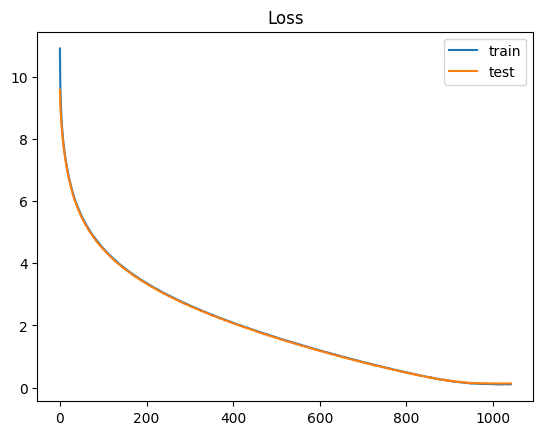

In [63]:
model_final = train_a_model(
            top_n_feature=70,
            batch_size=128,
            model_number=6,
            show_plots=True,
            append_result_list=False
)

Let's have a look at our test datapoints and its predictions

In [64]:
# preparing the data 
df_preprocessed = DataPreprocessor(df, 'SalePrice', 70)
X_train, X_test, y_train, y_test = df_preprocessed.preprocess_data()

In [70]:
device = 'cuda'

pred = model_final(torch.tensor(X_test.values.astype('float32')).to(device)).ravel().to('cpu').detach()
grund_truth = y_test.values

pd.DataFrame({'Pred':pred,'Truth':grund_truth}).applymap(lambda x: round(x)).head(30)


,Pred,Truth
0,136632,154500
1,299787,325000
2,112807,115000
3,160012,159000
4,337319,315500
5,85919,75500
6,227724,311500
7,144988,146000
8,81589,84500
9,123431,135500


Since it's a regression problem, let's evaluate the r2 score

In [66]:
print(f'r2_score: {r2_score(grund_truth,pred):.2f}')


r2_score: 0.91


With an R-squared score of 0.91, the model shows a robust predictive ability.